# Load Datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

+ X_label IMG

In [2]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [3]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [4]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)

In [5]:
# check np array is well defined
img_arr.shape

(1016, 150, 150, 3)

+ X_label Facial

In [6]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [7]:
imsi = pre_facial.copy()

In [8]:
# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [9]:
# check np array is well defined
fac_input.shape

(1016, 16)

+ X_label Color

In [10]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [11]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [12]:
# check np array is well defined
clr_input.shape

(1016, 3)

+ y_label

In [13]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

---

# Modeling w/ BP-MLL

Make Model using keras functional api

In [177]:
from keras.layers import Input
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

def multi_input_model(input_shape, classes):
    # IMG Conv Model (not in use)
    real_conv_input = tf.keras.Input(shape=(150,150,3,))
    # conv_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    conv_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(real_conv_input)
    conv_laye2 = tf.keras.layers.Dropout(0.2)(conv_layer)
    conv_laye3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye2)
    conv_laye4 = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(conv_laye3)
    conv_laye5 = tf.keras.layers.Dropout(0.2)(conv_laye4)
    conv_laye6 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye5)
    conv_laye7 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_laye6)
    conv_laye8 = tf.keras.layers.Dropout(0.2)(conv_laye7)
    conv_laye9 = tf.keras.layers.Flatten()(conv_laye8)
    #conv_lay10 = tf.keras.layers.Dense(64, activation='relu')(conv_laye9)
    #conv_output = tf.keras.layers.Dense(classes, activation='relu')(conv_lay10)
    
    # IMG ResNet Model
    # resnet_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    # resnet_input = tf.keras.Input(shape=(input_shape,input_shape,3))
    #resnet_resc = tf.keras.preprocessing.Rescaling(1.0/255)(resnet_input)
    # resnet_output = tf.keras.applications.ResNet50(weights=None, input_shape=(input_shape,input_shape,3), classes=classes)(resnet_input)
    
    # face MLP Model
    real_face_input = tf.keras.layers.Input(shape=(16,))
    #face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # face_layer = keras.layers.Dropout(0.2)(face_input)
    #face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    #face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    #face_output = tf.keras.layers.Dense(classes, activation='relu')(face_laye4)#(face_laye5)
    
    # # face MLP Model /w relu
    # real_face_input = tf.keras.layers.Input(shape=(16,))
    # face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # #face_layer = keras.layers.Dropout(0.2)(face_input)
    # face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # #face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    # face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # #face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    # face_output = tf.keras.layers.Dense(classes, activation='softmax')(face_laye4)#(face_laye5)
    
    
    
    # clr MLP Model
    real_clr_input = tf.keras.layers.Input(shape=(3,))
    #clr_input = tf.keras.layers.Dense(64, activation='relu')(real_clr_input)
    #clr_layer = tf.keras.layers.Dense(32, activation='relu')(clr_input)
    #clr_output = tf.keras.layers.Dense(classes, activation='relu')(clr_layer)
    
    
    # concatenate
    concat = tf.keras.layers.Concatenate(axis=-1)([conv_laye9, real_face_input, real_clr_input])
    
    # final model
    final_input = tf.keras.layers.Dense(128, activation='relu')(concat)
    final_layer = tf.keras.layers.Dropout(0.2)(final_input)
    final_laye2 = tf.keras.layers.Dense(128, activation='relu')(final_layer)
    final_laye3 = tf.keras.layers.Dropout(0.2)(final_laye2)
    fianl_laye4 = tf.keras.layers.Dense(64, activation='relu')(final_laye3)
    final_output = tf.keras.layers.Dense(classes, activation='sigmoid')(fianl_laye4)
    
    
    model = tf.keras.models.Model([real_conv_input, real_face_input, real_clr_input], final_output)
    
    return model





In [178]:
NUM_CLASSES = 7
IMG_SIZE = 150

In [186]:
model = multi_input_model(IMG_SIZE, NUM_CLASSES)

In [187]:
# you can see model summary

#tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [188]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)


model.compile(loss = 'binary_crossentropy',
              optimizer= 'adam',
              metrics=[tf.compat.v1.losses.log_loss, 'Precision', 'Recall', 'BinaryAccuracy']

              )

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [189]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=1234)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=1234)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=1234)
y_out_s = sklearn.utils.shuffle(y_out, random_state=123)

weigh = np.array([1/42, 1/89, 1/112, 1/370, 1/135, 1/250, 1/47, 1/347, 1/51, 1/230, 1/50])
weigh = weigh * 1205 / 11
cw = {0:weigh[0], 1:weigh[1], 2:weigh[2], 3:weigh[3], 4:weigh[4], 5:weigh[5], 6:weigh[6], 7:weigh[7], 8:weigh[8], 9:weigh[9], 10:weigh[10]}

In [190]:
img_arr_test = img_arr_s[900:]
fac_inp_test = fac_input_s[900:]
clr_inp_test = clr_input_s[900:]
y_out_test = y_out_s[900:]

img_arr_s = img_arr_s[:900]
fac_input_s = fac_input_s[:900]
clr_input_s = clr_input_s[:900]
y_out_s = y_out_s[:900]




In [191]:
with tf.device("/device:GPU:0"):
  history = model.fit(
  x=[img_arr_s,fac_input_s, clr_input_s],
  y=y_out_s,
  validation_split=0.2,
  epochs=500,
  callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=8)],
  #class_weight = cw,
  batch_size=32
)

Epoch 1/500
23/23 [==============================] - 2s 62ms/step - loss: 0.5284 - log_loss: 0.5265 - precision: 0.2161 - recall: 0.0696 - binary_accuracy: 0.7742 - val_loss: 0.5234 - val_log_loss: 0.5230 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.8087 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 1s 49ms/step - loss: 0.4790 - log_loss: 0.4794 - precision: 0.3654 - recall: 0.0198 - binary_accuracy: 0.8063 - val_loss: 0.5330 - val_log_loss: 0.5328 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.8087 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 1s 44ms/step - loss: 0.4700 - log_loss: 0.4713 - precision: 0.2500 - recall: 0.0010 - binary_accuracy: 0.8087 - val_loss: 0.4968 - val_log_loss: 0.4966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.8087 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 1s 44ms/step - loss: 0.4676 - log_loss: 0.46

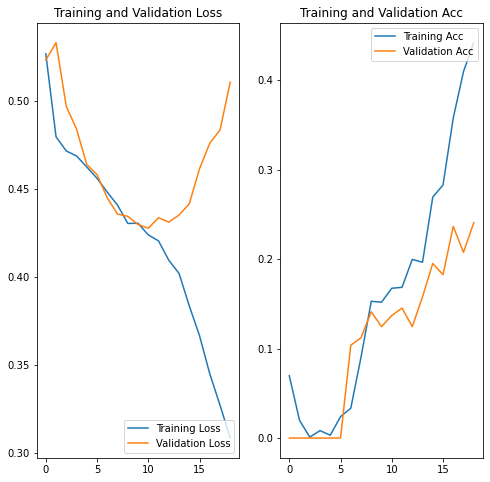

In [192]:
import matplotlib.pyplot as plt

acc = history.history['log_loss']
val_acc = history.history['val_log_loss']

loss = history.history['recall']
val_loss = history.history['val_recall']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Acc')
plt.plot(epochs_range, val_loss, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Acc')
plt.show()

In [54]:
#model.save('./models/cnn_7gen_3input.h5')

In [166]:
model.evaluate([img_arr_test,fac_inp_test,clr_inp_test], y_out_test)

4/4 [==============================] - 0s 16ms/step - loss: 0.5673 - log_loss: 0.5646 - precision: 0.3297 - recall: 0.1961 - binary_accuracy: 0.7734


[0.567281186580658,
 0.5646249055862427,
 0.32967033982276917,
 0.19607843458652496,
 0.7733989953994751]

In [193]:
2/(1/0.33 + 1/0.19)

0.2411538461538461

In [50]:
model.evaluate([img_arr_test,fac_inp_test,clr_inp_test], y_out_test)

4/4 [==============================] - 0s 17ms/step - loss: 1.4837 - log_loss: 1.3365 - precision: 0.4597 - recall: 0.3725 - binary_accuracy: 0.7993


[1.4836727380752563,
 1.3364759683609009,
 0.45967742800712585,
 0.37254902720451355,
 0.7992610335350037]

In [51]:
2/(1/0.46 + 1/0.37)

0.41012048192771083

In [52]:
k = model.predict([img_arr_test,fac_inp_test,clr_inp_test])

In [53]:
for i in range(20):
    print(k[i])
    print(y_out_test[i])

[2.3111143e-06 1.6395388e-08 1.0000000e+00 7.4351971e-07 1.9042652e-06
 6.3482104e-05 7.5675649e-05]
[0. 0. 1. 0. 0. 0. 0.]
[9.6876222e-01 2.1374977e-05 3.9662301e-04 9.7014701e-05 5.9331080e-05
 9.9052548e-01 9.9232167e-01]
[1. 0. 0. 0. 0. 1. 1.]
[3.7394781e-09 7.2938156e-10 1.0000000e+00 7.9755841e-07 1.3545443e-07
 5.8033368e-07 2.4981880e-06]
[0. 0. 1. 0. 0. 0. 0.]
[9.9999845e-01 2.2510061e-04 2.4263492e-05 8.4985015e-09 1.5124371e-06
 1.9035389e-06 1.6996951e-06]
[1. 0. 0. 0. 0. 0. 0.]
[3.1649515e-15 4.5754374e-15 2.1824185e-07 1.0000000e+00 2.6153759e-09
 6.1589102e-11 2.2318832e-10]
[0. 0. 0. 1. 0. 0. 0.]
[3.38161693e-10 3.50087390e-07 1.33182975e-05 2.43986960e-05
 9.99972820e-01 6.13511872e-08 5.03824324e-08]
[0. 0. 0. 0. 1. 0. 0.]
[1.1660520e-07 8.8807326e-07 3.4613222e-05 4.1359999e-05 1.8515320e-05
 9.9992073e-01 7.2216666e-05]
[0. 0. 0. 0. 0. 1. 0.]
[3.4525860e-06 3.5062887e-05 2.5243155e-05 1.6991767e-07 9.9995720e-01
 2.4643508e-05 2.8282555e-05]
[0. 0. 0. 0. 1. 0. 0.]
[

In [24]:
for genre in y_data.columns:
    print(genre, ': ', len(y_data[y_data[genre] == 1]))

Blues :  42
Electronic :  89
Folk, World, & Country :  112
Funk&Soul :  370
Hip Hop :  135
Jazz :  250
Latin :  47
Pop :  347
Reggae :  51
Rock :  230
Stage & Screen :  50


In [25]:
import numpy as np

a = np.array([0.19068299, 0.38264576, 0.5112294 , 0.91950315, 0.6525794 , 0.7625765 , 0.18932, 0.8939849 , 0.31639096, 0.84405494, 0.17323612])

In [94]:
import tensorflow as tf

b = tf.round(asdf)

In [26]:
asdf

array([[0.05662136, 0.16607894, 0.18742241, 0.37353346, 0.14911813,
        0.28890982, 0.11232238, 0.39391008, 0.14130892, 0.29082528,
        0.12739693],
       [0.14905626, 0.17031601, 0.20042908, 0.38828355, 0.25353763,
        0.3042009 , 0.15369332, 0.34080786, 0.16111292, 0.3143366 ,
        0.20126592],
       [0.04779759, 0.12222886, 0.19187751, 0.35770586, 0.17011602,
        0.24943049, 0.11327174, 0.3911908 , 0.12177941, 0.26476833,
        0.10248082]], dtype=float32)

In [96]:
def round_up(a):
    if a - int(a) >= 0.8:
        return int(a) + 1
    return int(a)

In [31]:
model.predict([img_arr_s[360:363],fac_input_s[360:363], clr_input_s[360:363]]) > 0.3

array([[False, False, False,  True, False, False, False,  True, False,
        False, False],
       [False, False,  True,  True,  True,  True, False,  True,  True,
         True,  True],
       [False, False, False,  True, False,  True, False,  True, False,
         True, False]])

In [107]:
y_out_s[360:363] > 0.8

array([[False, False, False, False,  True, False, False,  True, False,
        False, False],
       [False, False, False, False, False, False,  True,  True, False,
         True, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False]])

In [ ]:
import sklearn

sklearn.utils.class_weight.compute_class_weight()